<a href="https://colab.research.google.com/github/Antonyjaiwin/ML_ASSIGN-MODELS/blob/main/Drone_based_Tomato_Leaf_DiseaseClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from zipfile import ZipFile
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [2]:
zip_path = "/content/drive/MyDrive/tomato.zip"
if os.path.exists(zip_path):
    print("Unzipping", zip_path)
    with ZipFile(zip_path, 'r') as z:
        z.extractall("/content")
else:
    print("Warning: tomato.zip not found at", zip_path, "\nIf dataset is on Drive, mount Drive or upload the zip.")

Unzipping /content/drive/MyDrive/tomato.zip


In [3]:
DATA_ROOT = "/content/drive/MyDrive/tomato"
assert os.path.exists(DATA_ROOT), f"{DATA_ROOT} not found. Make sure the zip was extracted and has 'train' and 'val' folders."

# Show top-level structure
print("Top-level folders:", os.listdir(DATA_ROOT))

Top-level folders: ['val', 'train', '.ipynb_checkpoints']


# Dataset parameters

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_dir = os.path.join(DATA_ROOT, "train")
val_dir   = os.path.join(DATA_ROOT, "val")
assert os.path.isdir(train_dir) and os.path.isdir(val_dir), "train/ and val/ directories required in the tomato folder."

# Create tensorflow datasets

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


# Drone-like augmentation (pure TF)

In [6]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=SEED),
    layers.RandomRotation(0.12, seed=SEED),
    layers.RandomZoom(0.08, seed=SEED),
    layers.RandomTranslation(0.05, 0.05, seed=SEED),
    layers.RandomContrast(0.12, seed=SEED),
], name="data_augmentation")

In [7]:
def simulate_downsample_and_noise_tf(image):
    # image: float32, pixels in [0,255], shape [Batch_size, H, W, C]
    h = tf.shape(image)[1]
    w = tf.shape(image)[2]
    scale = tf.random.uniform([], 0.4, 1.0, dtype=tf.float32)

    def downsample():
        new_h = tf.cast(tf.maximum(10.0, tf.cast(h, tf.float32) * scale), tf.int32)
        new_w = tf.cast(tf.maximum(10.0, tf.cast(w, tf.float32) * scale), tf.int32)
        # Resize using tf.image.resize, which can handle batches
        small = tf.image.resize(image, [new_h, new_w], method='area')
        img2 = tf.image.resize(small, [h, w], method='bilinear')
        noise = tf.random.normal(tf.shape(img2), mean=0.0, stddev=3.0, dtype=tf.float32)
        img2 = img2 + noise
        img2 = tf.clip_by_value(img2, 0.0, 255.0)
        return img2

    # Use tf.cond with the batch dimension in mind
    return tf.cond(scale < 1.0, downsample, lambda: image)

# Motion blur approximation by depthwise conv with simple kernels (horizontal/vertical/diagonal)
def simulate_motion_blur_tf(image):
    # image: float32, pixels in [0,255], shape [Batch_size, H, W, C]
    prob = tf.random.uniform([], 0.0, 1.0)
    def apply_blur():
        ksize = tf.random.shuffle(tf.constant([7, 9, 11], dtype=tf.int32))[0]
        direction = tf.random.uniform([], 0, 2, dtype=tf.int32)  # 0=horiz, 1=vert

        if direction == 0:  # horizontal
            # Kernel shape: [kH, kW, in_channels, channel_multiplier]
            kernel_2d = tf.ones([1, ksize, 3, 1], tf.float32) / tf.cast(ksize, tf.float32)
        else:  # vertical
            # Kernel shape: [kH, kW, in_channels, channel_multiplier]
            kernel_2d = tf.ones([ksize, 1, 3, 1], tf.float32) / tf.cast(ksize, tf.float32)

        # Apply depthwise convolution on the batch
        blurred = tf.nn.depthwise_conv2d(image, kernel_2d, strides=[1,1,1,1], padding="SAME")
        return tf.clip_by_value(blurred, 0.0, 255.0)

    # Use tf.cond with the batch dimension in mind
    return tf.cond(prob < 0.35, apply_blur, lambda: image)

In [8]:
def preprocess_for_training(image, label):
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image)
    image = tf.image.random_brightness(image, max_delta=0.15 * 255.0, seed=SEED)
    image = simulate_downsample_and_noise_tf(image)
    image = simulate_motion_blur_tf(image)   # <- fixed version
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def preprocess_for_validation(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Map and performance optimizations
train_ds = train_ds.map(preprocess_for_training, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess_for_validation, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# Handle class imbalance (class weights)

In [9]:
def compute_class_weights(directory, class_names):
    counts = []
    for cls in class_names:
        path = os.path.join(directory, cls)
        counts.append(len(glob(os.path.join(path, "*"))))
    total = float(sum(counts))
    class_weights = {}
    for i, c in enumerate(counts):
        class_weights[i] = total / (len(counts) * (c + 1e-6))
    return class_weights, counts

class_weights, counts = compute_class_weights(train_dir, class_names)
print("Class counts:", dict(zip(class_names, counts)))
print("Class weights:", class_weights)

Class counts: {'Tomato___Bacterial_spot': 1000, 'Tomato___Early_blight': 1000, 'Tomato___Late_blight': 1000, 'Tomato___Leaf_Mold': 1000, 'Tomato___Septoria_leaf_spot': 1000, 'Tomato___Spider_mites Two-spotted_spider_mite': 1000, 'Tomato___Target_Spot': 1000, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 1000, 'Tomato___Tomato_mosaic_virus': 1000, 'Tomato___healthy': 1000}
Class weights: {0: 0.999999999, 1: 0.999999999, 2: 0.999999999, 3: 0.999999999, 4: 0.999999999, 5: 0.999999999, 6: 0.999999999, 7: 0.999999999, 8: 0.999999999, 9: 0.999999999}


# Build & compile model (MobileNetV2 transfer learning)

In [10]:
base_model = MobileNetV2(include_top=False, input_shape=(*IMG_SIZE, 3), weights='imagenet', pooling='avg')
base_model.trainable = False

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs, name="tomato_mobilenetv2")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "tomato_mobilenetv2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,514 (9.88 MB)

 Trainable params: 331,018 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

# Callbacks

In [11]:
checkpoint_path = "/content/tomato_mobilenetv2_best.h5"
callbacks = [
    keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
]

## Train (initial)

In [12]:
train_count = sum(counts)
val_count = sum([len(glob(os.path.join(val_dir, cls, "*"))) for cls in class_names])
print("Train images:", train_count, "Val images:", val_count)

EPOCHS = 12
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights
)

Train images: 10000 Val images: 1000
Epoch 1/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2432 - loss: 2.4873
Epoch 1: val_accuracy improved from -inf to 0.56200, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 1670s 5s/step - accuracy: 0.2436 - loss: 2.4858 - val_accuracy: 0.5620 - val_loss: 1.3050 - learning_rate: 1.0000e-04
Epoch 2/12
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.5306 - loss: 1.3941
Epoch 2: val_accuracy improved from 0.56200 to 0.61800, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 213s 674ms/step - accuracy: 0.5308 - loss: 1.3934 - val_accuracy: 0.6180 - val_loss: 1.1230 - learning_rate: 1.0000e-04
Epoch 3/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.6087 - loss: 1.1574
Epoch 3: val_accuracy did not improve from 0.61800
313/313 ━━━━━━━━━━━━━━━━━━━━ 213s 676ms/step - accuracy: 0.6088 - loss: 1.1573 - val_accuracy: 0.6180 - val_loss: 1.1054 - learning_rate: 1.0000e-04
Epoch 4/12
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.6544 - loss: 1.0267
Epoch 4: val_accuracy improved from 0.61800 to 0.62500, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 211s 670ms/step - accuracy: 0.6545 - loss: 1.0265 - val_accuracy: 0.6250 - val_loss: 1.0730 - learning_rate: 1.0000e-04
Epoch 5/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.6751 - loss: 0.9678
Epoch 5: val_accuracy did not improve from 0.62500
313/313 ━━━━━━━━━━━━━━━━━━━━ 214s 679ms/step - accuracy: 0.6751 - loss: 0.9678 - val_accuracy: 0.6190 - val_loss: 1.0835 - learning_rate: 1.0000e-04
Epoch 6/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 665ms/step - accuracy: 0.6911 - loss: 0.9139
Epoch 6: val_accuracy improved from 0.62500 to 0.62700, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 212s 676ms/step - accuracy: 0.6911 - loss: 0.9138 - val_accuracy: 0.6270 - val_loss: 1.0475 - learning_rate: 1.0000e-04
Epoch 7/12
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.7137 - loss: 0.8467
Epoch 7: val_accuracy improved from 0.62700 to 0.63000, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 209s 666ms/step - accuracy: 0.7137 - loss: 0.8467 - val_accuracy: 0.6300 - val_loss: 1.0603 - learning_rate: 1.0000e-04
Epoch 8/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.7228 - loss: 0.8126
Epoch 8: val_accuracy did not improve from 0.63000
313/313 ━━━━━━━━━━━━━━━━━━━━ 210s 668ms/step - accuracy: 0.7228 - loss: 0.8125 - val_accuracy: 0.6110 - val_loss: 1.0856 - learning_rate: 1.0000e-04
Epoch 9/12
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.7268 - loss: 0.8098
Epoch 9: val_accuracy did not improve from 0.63000

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
313/313 ━━━━━━━━━━━━━━━━━━━━ 213s 678ms/step - accuracy: 0.7268 - loss: 0.8098 - val_accuracy: 0.6000 - val_loss: 1.0976 - learning_rate: 1.0000e-04
Epoch 10/12
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.7396 - loss: 0.7681
Epoch 10: val_accuracy did not improve from 0.63000
313/313 ━━━━━━━━━━━━━━━━━━━━ 215s 683ms/step - accuracy: 

# Fine-tune (unfreeze top of base model)

In [13]:
base_model.trainable = True
fine_tune_at = int(len(base_model.layers) * 0.8)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fine_epochs = 8
total_epochs = EPOCHS + fine_epochs
print("Fine-tuning for", fine_epochs, "epochs (total epochs:", total_epochs, ")")
history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=callbacks,
    class_weight=class_weights
)

# Save final model
model.save("/content/tomato_mobilenetv2_final.h5")
print("Saved model to /content/tomato_mobilenetv2_final.h5")

Fine-tuning for 8 epochs (total epochs: 20 )
Epoch 13/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 675ms/step - accuracy: 0.6601 - loss: 1.0156
Epoch 13: val_accuracy did not improve from 0.63000
313/313 ━━━━━━━━━━━━━━━━━━━━ 245s 711ms/step - accuracy: 0.6602 - loss: 1.0153 - val_accuracy: 0.5790 - val_loss: 1.9740 - learning_rate: 1.0000e-05
Epoch 14/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.7420 - loss: 0.7905
Epoch 14: val_accuracy did not improve from 0.63000
313/313 ━━━━━━━━━━━━━━━━━━━━ 214s 680ms/step - accuracy: 0.7420 - loss: 0.7904 - val_accuracy: 0.6170 - val_loss: 1.5905 - learning_rate: 1.0000e-05
Epoch 15/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7572 - loss: 0.7256
Epoch 15: val_accuracy improved from 0.63000 to 0.64800, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 263s 683ms/step - accuracy: 0.7573 - loss: 0.7254 - val_accuracy: 0.6480 - val_loss: 1.3033 - learning_rate: 1.0000e-05
Epoch 16/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.7675 - loss: 0.6565
Epoch 16: val_accuracy improved from 0.64800 to 0.65700, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 214s 677ms/step - accuracy: 0.7676 - loss: 0.6564 - val_accuracy: 0.6570 - val_loss: 1.1948 - learning_rate: 1.0000e-05
Epoch 17/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.8031 - loss: 0.5831
Epoch 17: val_accuracy improved from 0.65700 to 0.68700, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 211s 668ms/step - accuracy: 0.8032 - loss: 0.5831 - val_accuracy: 0.6870 - val_loss: 1.0280 - learning_rate: 1.0000e-05
Epoch 18/20
312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.8165 - loss: 0.5461
Epoch 18: val_accuracy improved from 0.68700 to 0.69200, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 263s 673ms/step - accuracy: 0.8165 - loss: 0.5461 - val_accuracy: 0.6920 - val_loss: 0.9925 - learning_rate: 1.0000e-05
Epoch 19/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 661ms/step - accuracy: 0.8245 - loss: 0.5230
Epoch 19: val_accuracy improved from 0.69200 to 0.69500, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 213s 673ms/step - accuracy: 0.8245 - loss: 0.5230 - val_accuracy: 0.6950 - val_loss: 0.9310 - learning_rate: 1.0000e-05
Epoch 20/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.8291 - loss: 0.5085
Epoch 20: val_accuracy improved from 0.69500 to 0.70000, saving model to /content/tomato_mobilenetv2_best.h5


313/313 ━━━━━━━━━━━━━━━━━━━━ 214s 678ms/step - accuracy: 0.8291 - loss: 0.5085 - val_accuracy: 0.7000 - val_loss: 0.8903 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 20.


Saved model to /content/tomato_mobilenetv2_final.h5


# Evaluation

In [14]:
y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    probs = model.predict(images, verbose=0)  # shape (batch, num_classes)
    preds = np.argmax(probs, axis=1)
    trues = np.argmax(labels.numpy(), axis=1)
    y_true.extend(trues.tolist())
    y_pred.extend(preds.tolist())
    y_prob.extend(probs.tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

Classification Report:
                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     0.8667    0.2600    0.4000       100
                        Tomato___Early_blight     1.0000    0.2100    0.3471       100
                         Tomato___Late_blight     0.9306    0.6700    0.7791       100
                           Tomato___Leaf_Mold     0.9545    0.6300    0.7590       100
                  Tomato___Septoria_leaf_spot     0.3750    0.9600    0.5393       100
Tomato___Spider_mites Two-spotted_spider_mite     0.7593    0.8200    0.7885       100
                         Tomato___Target_Spot     0.5680    0.7100    0.6311       100
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     1.0000    0.8800    0.9362       100
                 Tomato___Tomato_mosaic_virus     0.8241    0.8900    0.8558       100
                             Tomato___healthy     0.7698    0.9700    0.8584       100

                  

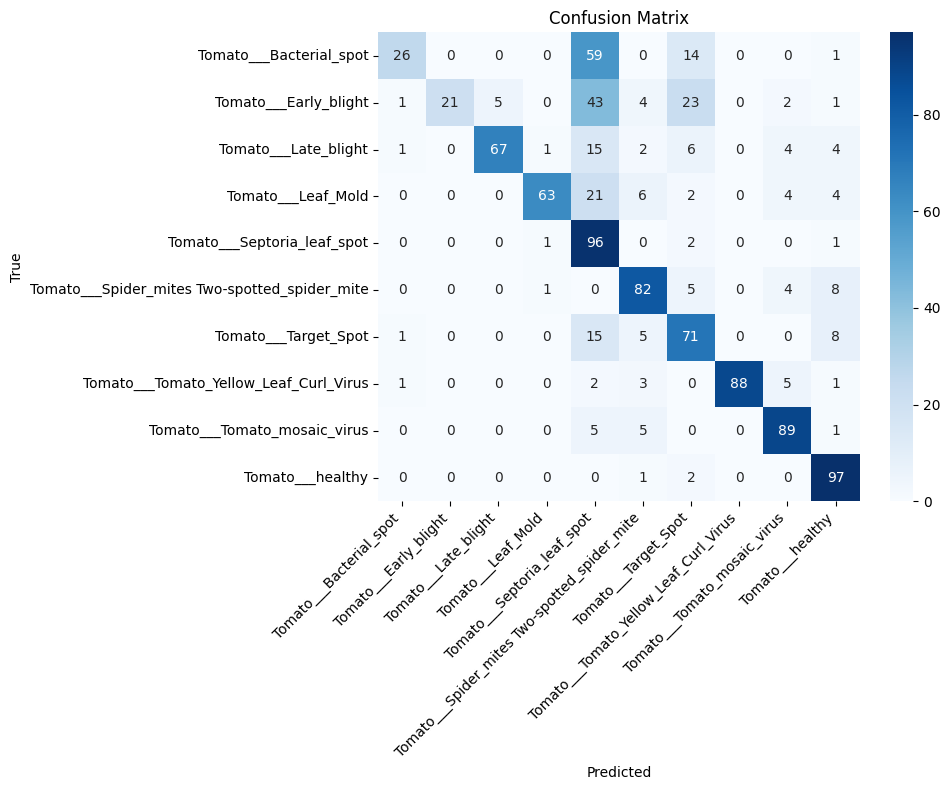

In [15]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

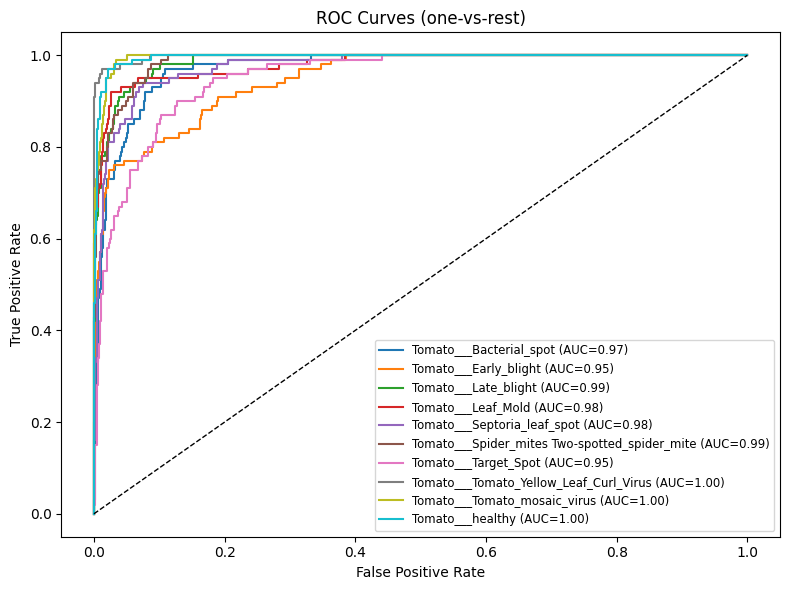

In [16]:
y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
fpr = dict(); tpr = dict(); roc_auc = dict()
precision = dict(); recall = dict(); pr_auc = dict()

for i in range(num_classes):
    if np.sum(y_true_bin[:, i]) == 0:
        # no samples for this class in val -> skip
        fpr[i], tpr[i], roc_auc[i] = [None], [None], None
        precision[i], recall[i], pr_auc[i] = [None], [None], None
        continue
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

# Plot ROC (only classes present)
plt.figure(figsize=(8,6))
for i in range(num_classes):
    if roc_auc[i] is None:
        continue
    plt.plot(fpr[i], tpr[i], lw=1.5, label=f"{class_names[i]} (AUC={roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (one-vs-rest)")
plt.legend(loc='lower right', fontsize='small')
plt.tight_layout()
plt.show()

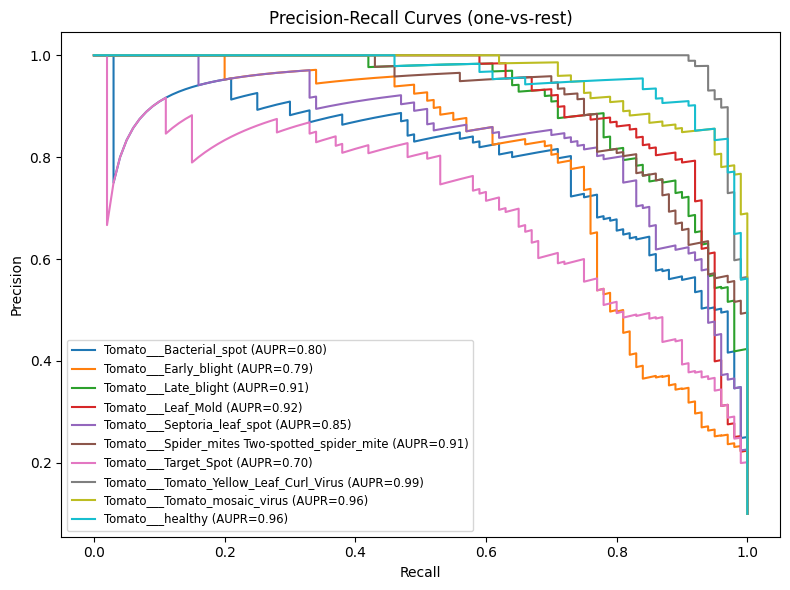

In [17]:
plt.figure(figsize=(8,6))
for i in range(num_classes):
    if pr_auc[i] is None:
        continue
    plt.plot(recall[i], precision[i], lw=1.5, label=f"{class_names[i]} (AUPR={pr_auc[i]:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (one-vs-rest)")
plt.legend(loc='lower left', fontsize='small')
plt.tight_layout()
plt.show()

# Visualize predictions on a few validation samples

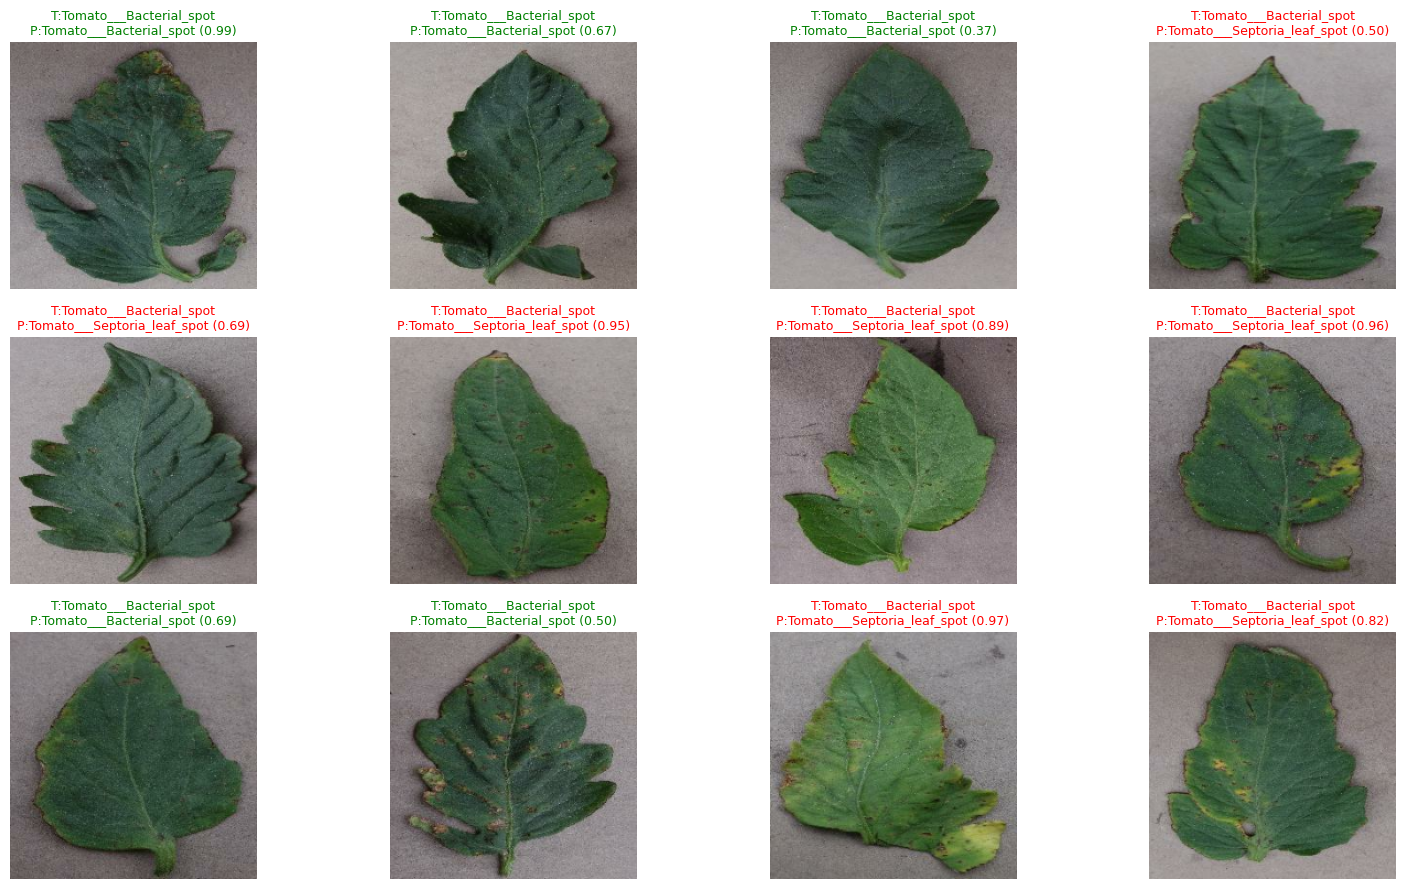

In [18]:
import math

def show_sample_predictions(model, ds, class_names, n=12):
    images_list = []
    true_list = []
    pred_list = []
    prob_list = []
    # we unbatch to pick single images (preprocessed)
    it = ds.unbatch().as_numpy_iterator()
    for _ in range(n):
        try:
            img, lbl = next(it)
        except StopIteration:
            break
        # model expects batch
        probs = model.predict(np.expand_dims(img, axis=0), verbose=0)[0]
        pred = np.argmax(probs)
        images_list.append(img)
        true_list.append(np.argmax(lbl))
        pred_list.append(pred)
        prob_list.append(probs[pred])
    cols = 4
    rows = math.ceil(len(images_list)/cols)
    plt.figure(figsize=(4*cols, 3*rows))
    for i, img in enumerate(images_list):
        plt.subplot(rows, cols, i+1)
        # inverse mobileNet preprocess: from [-1,1] to [0,255]
        disp = (img + 1.0) * 127.5
        disp = np.clip(disp.astype("uint8"), 0, 255)
        plt.imshow(disp)
        title = f"T:{class_names[true_list[i]]}\nP:{class_names[pred_list[i]]} ({prob_list[i]:.2f})"
        color = "green" if true_list[i] == pred_list[i] else "red"
        plt.title(title, color=color, fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_predictions(model, val_ds, class_names, n=12)

# Training curves

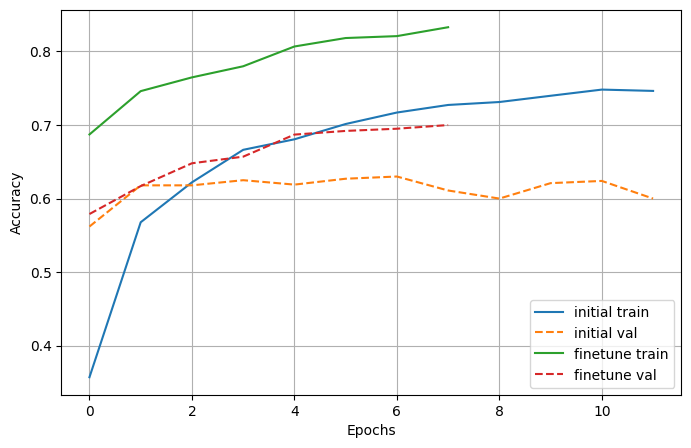

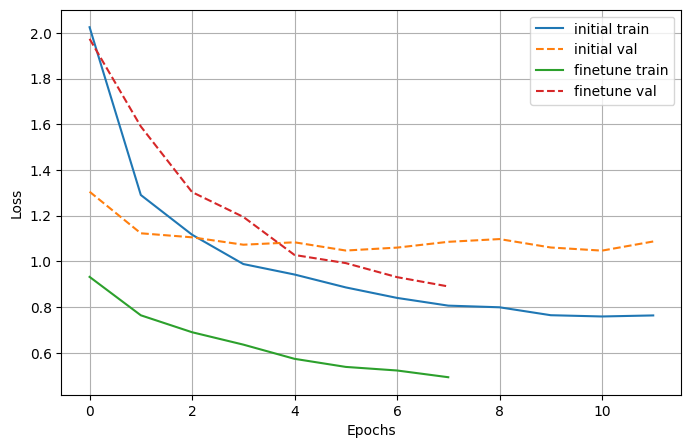

In [19]:
def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(8,5))
    for name, history in histories:
        plt.plot(history.history[key], label=f"{name} train")
        plt.plot(history.history['val_'+key], '--', label=f"{name} val")
    plt.xlabel("Epochs")
    plt.ylabel(key.title())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history([("initial", history), ("finetune", history_ft)], key='accuracy')
plot_history([("initial", history), ("finetune", history_ft)], key='loss')

# Utility: predict single image

In [20]:
def predict_image(path: str, model):
    img = tf.keras.utils.load_img(path, target_size=IMG_SIZE)
    arr = tf.keras.utils.img_to_array(img)
    arr = tf.cast(arr, tf.float32)
    arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
    probs = model.predict(np.expand_dims(arr, axis=0), verbose=0)[0]
    idx = np.argmax(probs)
    return class_names[idx], float(probs[idx])

example_paths = glob(os.path.join(val_dir, "**", "*.jpg"), recursive=True)[:3]
for p in example_paths:
    label, conf = predict_image(p, model)
    print(os.path.basename(p), "->", label, f"({conf:.3f})")

1f2dc4ae-5264-443a-a103-67fafb37bc70___GHLB_PS Leaf 26.1 Day 16.jpg -> Tomato___Late_blight (0.999)
0b988f87-fdce-40ba-aa09-7e6c9e1d6d30___GHLB_PS Leaf 21 Day 8.jpg -> Tomato___Late_blight (0.990)
1f38a263-cfb5-47fe-8c0e-f8d62141f922___GHLB_PS leaf 28 Day 12 .jpg -> Tomato___Late_blight (0.869)
